<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Studentized-Bootstrap" data-toc-modified-id="The-Studentized-Bootstrap-1">The Studentized Bootstrap</a></span><ul class="toc-item"><li><span><a href="#Repair-Times" data-toc-modified-id="Repair-Times-1.1">Repair Times</a></span></li><li><span><a href="#Comparing-Distributions-of-the-Statistic" data-toc-modified-id="Comparing-Distributions-of-the-Statistic-1.2">Comparing Distributions of the Statistic</a></span></li><li><span><a href="#The-Studentized-Bootstrap-Procedure" data-toc-modified-id="The-Studentized-Bootstrap-Procedure-1.3">The Studentized Bootstrap Procedure</a></span></li><li><span><a href="#Computing-the-Standard-Error-of-the-Resample-Statistic" data-toc-modified-id="Computing-the-Standard-Error-of-the-Resample-Statistic-1.4">Computing the Standard Error of the Resample Statistic</a></span></li><li><span><a href="#Comparison-of-Studentized-Bootstrap-with-Percentile-Bootstrap" data-toc-modified-id="Comparison-of-Studentized-Bootstrap-with-Percentile-Bootstrap-1.5">Comparison of Studentized Bootstrap with Percentile Bootstrap</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2">Summary</a></span></li></ul></div>

In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [3]:
# Generate a bunch of random points. To change the dataset, just
# change this line and rerun notebook
times = (np.random.exponential(scale=300, size=13825) +
         np.abs(np.random.normal(loc=50, scale=40, size=13825)))

## The Studentized Bootstrap



**NOTE: Outline is kept here for reference -ak**
<font color='red'>
- Briefly review percentile bootstrap confidence interval procedure
    - Make distinction to call this the "percentile bootstrap" method since we will introduce a new method in this section.
- Briefly review bootstrap CI confidence meaning
    - 95% confidence = 95% probability that taking a new sample from population and making bootstrap CI will have the parameter
- However, this probability is not exactly 95%

- We've taken a population and created one thousand bootstrap CIs for the population mean at each sample size from 4 to 100.
    - Notice that at sample sizes below 20, fewer than 90% of the CIs actually contain the population parameter, not 95%.

The **bootstrap** is a process we learned about in Data 8 that we can use for estimating a population statistic using only one sample. The general procedure for bootstrapping is as follows:
- Draw a sizable sample from the population.
- Using this sample, we *resample with replacement* to form new samples of the same size.
- We do this many times, taking the desired statistic of each resample (e.g. we take the median of each resample).

Here, we end up with many test statistics from individual resamples, from which we can form a distribution. In Data 8, we were taught to form a confidence interval by taking the 2.5th percentile and the 97.5th percentile. This method of bootstrapping to create a confidence interval is called the **percentile bootstrap.** Generally speaking, this confidence interval will have a 95% chance of containing the actual population statistic. It is important to note, however, that this will NOT always be the case. 

Below, we've taken a population and created one thousand bootstrap *confidence intervals* for the population mean for different sample sizes. The y-axis represents the fraction of the one thousand confidence intervals that contained the real population mean. Notice that at sample sizes below 20, fewer than 90% of the confidence intervals actually contain the population mean.

In [42]:
# Since this plot needs a bunch of prior code to run, I suggest
# saving this plot as a .png and then just including the picture without the
# code in the final notebook
# trials['percentile'].plot()
# plt.axhline(0.95, c='red', linestyle='--', label='95% coverage');

<img src="trials.png">

<font color='red'>
- Coverage error is the difference between the desired 95% confidence and reality.
- We can see that the coverage error for our bootstrap method is rather high at small sample sizes.
- We will introduce a new bootstrap method that has lower coverage error but requires more computation.

We can measure *coverage error* by calculating the difference between our measured confidence here and our desired 95% confidence. We can see that the coverage error for percentile bootstrap is very high at small sample sizes. In this chapter, we will introduce a new bootstrap method, called the **studentized bootstrap** method, that has a lower coverage error but requires more computation.

### Repair Times
<font color='red'>
- Introduce dataset: population of repair times (need Deb for more background)
- Plot data

Blah blah stuff about repair times and stuff. Here we plot the data. (need Deb for more background)

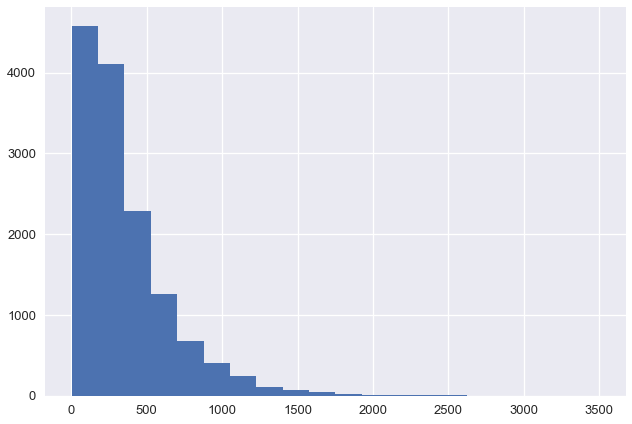

In [13]:
plt.hist(times, bins=20);

<font color='red'>
- We are estimating the population mean

Let's say we want to estimate the population mean of the repair times. We first need to define the main statistic function needed to do this. By passing in the whole population, we can see that actual average repair time is about 354.

In [14]:
def stat(sample, axis=None):
    return np.mean(sample, axis=axis)

In [15]:
theta = stat(times)
theta

353.71148132542334

<font color='red'>
- Define method to take sample of size 10 from population

Now we need to define a method that will return a list of indices so we can resample from the original sample without replacement.

In [18]:
def take_sample(n=10):
    return np.random.choice(times, size=n, replace=False)

<font color='red'>
- Normally, we aren't able to draw many samples from the population. This time, we have access to the population so we will take many samples of size 10 and plot the distribution of sample means:

In real life, we won't be able to draw many samples from the population (we use bootstrap to be able to use just one sample). But for demonstration purposes, we have access to the entire population, so we will take 1000 samples of size 10 and plot the distribution of the sample means.

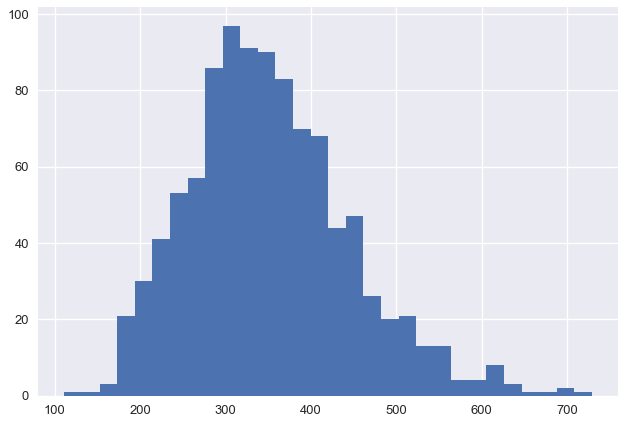

In [19]:
samples_from_pop = 1000

pop_sampling_dist = np.array(
    [stat(take_sample()) for _ in range(samples_from_pop)]
)

plt.hist(pop_sampling_dist, bins=30);

<font color='red'>
- We see that this distribution is slightly skewed right because of the skewed distribution of the original data.

We can see that the center of this distribution is ~350, and that it is skewed right because of the skewed distribution of the original data. 

### Comparing Distributions of the Statistic
<font color='red'>
- We use $ \theta $ to refer to the population parameter
    - In this case, the average repair time
- We use $ \hat \theta $ to refer to the sample statistic
    - In this case, the average repair time of a sample.
    - The plot above shows an empirical distribution of $ \hat \theta $.
- Recall that the bootstrap procedure takes a resample of the original sample. For each resample, we calculate $ \tilde \theta $, the statistic of the resample.
    - In this case, the average repair time of a resample.
- In order for the bootstrap to work, we need the sample to look similar to the population so that the resample also looks similar to the population.
- If this is true, the distribution of average repair times using the resamples will look similar to the distribution of average repair times using multiple samples from the population.


- We now take a sample of size 10 and bootstrap it 1000 times, plotting the distribution of $ \tilde \theta $.

Now we can look at how a single bootstrap distribution can stack up against a distribution sampled from the population. 

Generally, we are aiming to estimate $\theta$, our population parameter (in this case, the average repair time of the population, which we found to be ~354). Each individual sample can be used to calculate an estimated statistic, $\hat\theta$ (in this case, the average repair time of a single sample). The plot above shows what we call an *empirical distribution* of $\hat\theta$, which is calculated of many estimated statistics from many samples from the population. For the bootstrap, however, we want the statistic of the resample of the original sample, which is called $\tilde\theta$. 

In order for the bootstrap to work, we want our original sample to look similar to the population, so that resamples also look similar to the population. If our original sample *does* look like the population, then the distribution of average repair times calculated from the resamples will look similar to the empirical distribution of samples directly from the population.

Let's take a look at how an individual bootstrap distribution will look. We can define methods to take samples of size 10 without replacement and bootstrap it 1000 times to get our distribution.

In [43]:
bootstrap_reps = 1000

def resample(sample, reps):
    n = len(sample)
    return np.random.choice(sample, size=reps * n).reshape((reps, n))

def bootstrap_stats(sample, reps=bootstrap_reps, stat=stat):
    resamples = resample(sample, reps)
    return stat(resamples, axis=1)

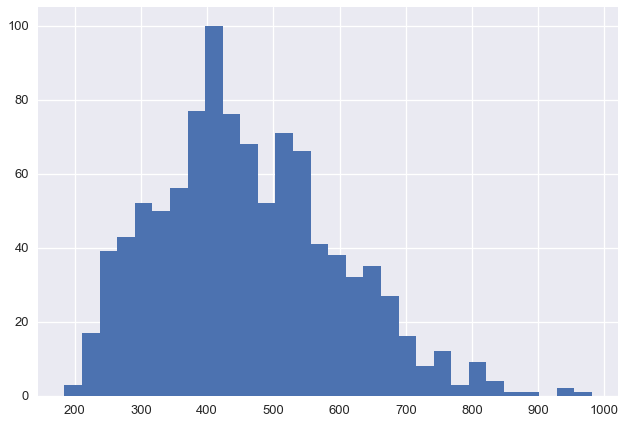

In [30]:
np.random.seed(0)

sample = take_sample()

plt.hist(bootstrap_stats(sample), bins=30);

<font color='red'>
- As you can see, the distribution of $ \tilde \theta $ doesn't look like the distribution of $ \hat \theta $.
- This causes the percentile CI to perform poorly.
- Side-by-side comparison:

As you can see, our distribution of $\tilde\theta$ doesn't look *quite* like the distribution of $\hat\theta$, likely because our original sample did not look like the population. As a result, our confidence intervals perform rather poorly. Below we can see a side-by-side comparison of the two distributions:

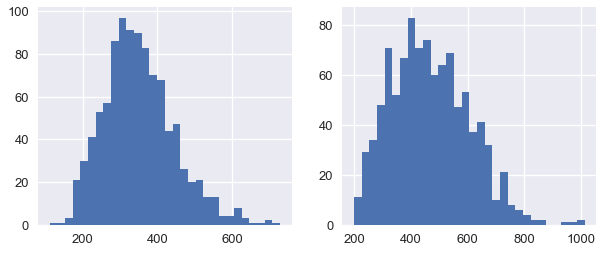

In [24]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(pop_sampling_dist, bins=30);

plt.subplot(122)
plt.hist(bootstrap_stats(sample), bins=30);

### The Studentized Bootstrap Procedure

<font color='red'>
- Idea: normalize the distribution of the test statistic $ \tilde \theta $ to be centered at 0 and have a standard deviation of 1.
- This corrects for the spread difference and skew of the test statistic distribution. (Probably want more clarification from Deb here.)
- However, we will need some derivation to make this work

As we saw, the main issue with percentile bootstrap procedure is that it takes a larger sample size to really reach the desired 95% confidence. With the studentized bootstrap procedure, we can do a little more calculation to get better coverage at smaller sample sizes.

The idea behind the studentized bootstrap procedure is to normalize the distribution of the test statistic $\tilde\theta$ to be centered at 0 and have a standard deviation of 1. This will correct for the spread difference and skew of the original distribution. In order to do all of this, we need to do some derivation first.

<font color='red'>
- In the percentile method, we generate many values of $ \tilde \theta $, then take the 2.5th and 97.5th percentiles of these values for our CI.
    - We use the notation $ q_{2.5} $ and $ q_{97.5} $ to refer to these percentiles.
    - Note that both of these values come from the bootstrap statistics

- We hope that:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \theta \leq q_{97.5}\right)
\end{aligned}
$$

- That is, we hope that the population parameter has a 95% chance of being in a confidence interval created from a new sample from the population.
- We make two approximations: since a random sample looks like the population, we approximate $ \theta $ with $ \hat \theta $. Since a random resample looks like the original sample, we we approximate $ \hat \theta $ with $ \tilde \theta $.
- These approximations introduce error into the CI generation which results in the coverage error we see above.

In the percentile bootstrap procedure, we generate many values of $\tilde\theta$, and then we take the 2.5th and 97.5th percentiles for our confidence interval. For short, we refer to these percentiles as $q_{2.5}$ and $q_{97.5}$. Note that both of these values come from the bootstrap statistics.

With this procedure, we hope that the probability that the actual population statistic lies between our confidence intervals is about 95%. In other words, we hope for the following equality:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \theta \leq q_{97.5}\right)
\end{aligned}
$$

We make two approximations during this procedure: since we assume our random sample looks like the population, we approximate $\theta$ with $\hat\theta$; since we assume a random resample looks like the original sample, we approximate $\hat\theta$ with $\tilde\theta$. Since the second approximation relies on the first one, they both introduce error in the confidence interval generation, which creates the coverage error we saw in the plot.

<font color='red'>
- We reduce this error by normalizing our statistic.
    - instead of using $ \tilde \theta $ directly, we use:
    
$$
\begin{aligned}
\frac
    {\tilde{\theta} - {\hat{\theta}}}
    {SE({\tilde{\theta}})}
\end{aligned}
$$

- First, we normalize the statistic by the sample statistic
- Then, we divide by the standard deviation of the resample statistic (also called the standard error, or SE).
- This normalized statistic is called the Student's t-statistic, so we call this bootstrap method the Studentized bootstrap or the bootstrap-$t$ method.

We aim to reduce this error by normalizing our statistic. Instead of using our calculated value of $\tilde\theta$ directly, we use: 

$$
\begin{aligned}
\frac
    {\tilde{\theta} - {\hat{\theta}}}
    {SE({\tilde{\theta}})}
\end{aligned}
$$

This will normalize the resample statistic by the sample statistic, and then divide by the standard deviation of the resample statistic (this standard deviation is also called the standard error, or SE).

This whole normalized statistic is called the Student's t-statistic, so we call this bootstrap method the **studentized bootstrap** or the **bootstrap-t** method.

<font color='red'>
- As usual, we compute many of these statistics, then take the 2.5th and 97.5th percentiles — $ q_{2.5} $ and $ q_{97.5} $.
- We hope that the normalized population parameter lies between these percentiles:

As usual, we compute this statistic for many resamples, and then take the 2.5th and 97.5th percentiles — $ q_{2.5} $ and $ q_{97.5} $. As such, we hope that the normalized population parameter lies between these percentiles:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \frac{\hat{\theta} - \theta} {SE({\hat{\theta}})} \leq q_{97.5}\right) \\
\end{aligned}
$$

<font color='red'>
- Solving the inequality for $ \theta $:

We can now solve the inequality for $\theta$:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \frac{\hat{\theta} - \theta} {SE({\hat{\theta}})} \leq q_{97.5}\right) \\
 &= {\cal P}\left(q_{2.5}SE({\hat{\theta}}) \leq {\hat{\theta} - \theta} \leq q_{97.5}SE({\hat{\theta}})\right) \\
 &= {\cal P}\left(\hat{\theta} - q_{97.5}SE({\hat{\theta}}) \leq {\theta} \leq \hat{\theta} - q_{2.5}SE({\hat{\theta}})\right) 
\end{aligned}
$$

<font color='red'>
- This means we can create a 95% confidence interval using:
    - $ \hat{\theta} $, the test statistic computed on the sample.
    - $ q_{2.5} $ and $ q_{97.5} $, the percentiles of the normalized statistic computed on the resamples.
    - $ SE(\hat \theta) $, the standard deviation of the sample test statistic. We estimate this quantity by using the standard deviation of the resample test statistics.

This means we can construct our confidence interval using just $\hat\theta$ (the test statistic on the original sample), $q_{2.5}$ and $q_{97.5}$ (the percentiles of the normalized statistic computed with the resamples), and $SE(\hat\theta)$ (the standard deviation of the sample test statistic). This last value is estimated by using the standard deviation of the resample test statistics.

<font color='red'>
- Thus, to compute a studentized bootstrap CI, we perform the following procedure:


1. Compute $ \hat{\theta} $, the test statistic on the sample.
1. Bootstrap the sample a large number of times.
1. For each bootstrap resample:
    1. Compute $ \tilde \theta $, the test statistic on the resample.
    1. Compute $ SE({\tilde{\theta}}) $.
    1. Compute $ q =  \frac{\tilde{\theta} - {\hat{\theta}}}{SE({\tilde{\theta}})} $.
1. Estimate $ SE(\hat \theta) $ using the standard deviation of the $ \tilde \theta $ values.
1. The confidence interval is thus: $ \left[ \hat{\theta} - q_{97.5}SE({\hat{\theta}}), \hat{\theta} - q_{2.5}SE({\hat{\theta}}) \right] $.

Thus, to compute a studentized bootstrap CI, we perform the following procedure:

1. Compute $ \hat{\theta} $, the test statistic on the sample.
1. Bootstrap the sample a large number of times.
1. For each bootstrap resample:
    1. Compute $ \tilde \theta $, the test statistic on the resample.
    1. Compute $ SE({\tilde{\theta}}) $.
    1. Compute $ q =  \frac{\tilde{\theta} - {\hat{\theta}}}{SE({\tilde{\theta}})} $.
1. Estimate $ SE(\hat \theta) $ using the standard deviation of the $ \tilde \theta $ values.
1. Calculate the confidence intervals thusly: $ \left[ \hat{\theta} - q_{97.5}SE({\hat{\theta}}), \hat{\theta} - q_{2.5}SE({\hat{\theta}}) \right]$.

### Computing the Standard Error of the Resample Statistic
<font color='red'>

- Note that $ SE(\tilde \theta) $, the standard error of the resample test statistic, is not always easy to compute.
- For the sample mean, $ SE(\tilde \theta) = \frac{\tilde \sigma}{\sqrt n} $, the standard deviation of the resample values divided by the square root of the sample size.
    - Note that we have to use the resample values to compute $ SE(\tilde \theta) $; we use the sample values to compute $ SE(\hat \theta) $.

It is important to note that $SE(\hat\theta)$, the standard error of the resample test statistic, is not always easy to compute and is dependent on the test statistic. For the sample mean, $SE(\tilde\theta)=\frac{\tilde\sigma}{\sqrt{n}}$, the standard deviation of the resample values divided by the square root of the sample size. 

Also remember that we have to use the resample values to compute $ SE(\tilde \theta) $; we use the sample values to compute $ SE(\hat \theta) $.

<font color='red'>

- However, if the SE doesn't have an analytic expression, we have to do a second-level bootstrap. We bootstrap each resample, compute the test stat on each second level resample, and compute the standard deviation of the second level test stats.
    - Typically we do around 50 second-level resamples
- This increases computation time for the studentized bootstrap CI.
    - If we do 50 second-level resamples, the entire procedure takes around 50 times as long.

If our test statistic, however, does not have an analytic expression (like the one we have for the sample mean), then we need to do a second-level bootstrap. For each resample, we bootstrap it again, and compute the test statistic on each second-level resample (the resampled resample), and compute the standard deviation using these second-level statistics. Typically, we do around 50 second-level resamples.

This greatly increases computation time for the studentized bootstrap procedure. If we do 50 second-level resamples, the entire procedure will take 50 times as long as if we just had an analytic expression for $SE(\tilde\theta)$.

### Comparison of Studentized Bootstrap with Percentile Bootstrap

<font color='red'>
- Now we compare the coverage of the two methods using the repair times dataset

To assess the tradeoffs of studentized and percentile bootstrap, let's compare the coverage of the two methods using the repair times dataset.

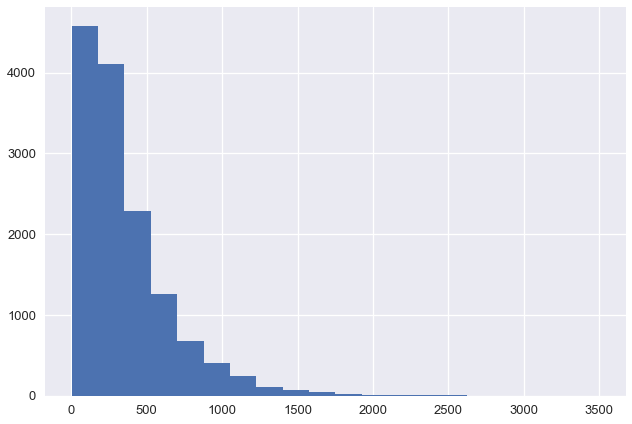

In [27]:
plt.hist(times, bins=20);

<font color='red'>

- We will take many samples from the population, compute a percentile CI and studentized CI for each sample, and compute the coverage.
- We repeat this for many sample sizes to see how the coverage changes with the sample size

We will take many samples from the population, compute a percentile confidence interval and a studentized confidence interval for each sample, and then compute the coverage for each. We will repeat this for varying sample sizes to see how the coverage of each method changes with sample size.

<font color='red'>

- To compute percentile CI:

We can use `np.percentile` to compute the percentile confidence interval below:

In [31]:
def percentile_ci(sample, reps=bootstrap_reps, stat=stat):
    stats = bootstrap_stats(sample, reps, stat)
    return np.percentile(stats, [2.5, 97.5])

In [32]:
np.random.seed(0)
sample = take_sample(n=10)
percentile_ci(sample)

array([ 239.85,  756.91])

<font color='red'>

- To compute studentized bootstrap, we need a lot more code:

To do the studentized bootstrap, we need a lot more code:

In [33]:
def studentized_stats(sample, reps=bootstrap_reps, stat=stat):
    '''
    Computes studentized test statistics for the provided sample.
    
    Returns the studentized test statistics and the SD of the
    resample test statistics.
    '''
    # Bootstrap the sample and compute \tilde \theta values
    resamples = resample(sample, reps)
    resample_stats = stat(resamples, axis=1)
    resample_sd = np.std(resample_stats)
    
    # Compute SE of \tilde \theta.
    # Since we're estimating the sample mean, we can use the formula.
    # Without the formula, we would have to do a second level bootstrap here.
    resample_std_errs = np.std(resamples, axis=1) / np.sqrt(len(sample))
    
    # Compute studentized test statistics (q values)
    sample_stat = stat(sample)
    t_statistics = (resample_stats - sample_stat) / resample_std_errs
    return t_statistics, resample_sd
 
def studentized_ci(sample, reps=bootstrap_reps, stat=stat):
    '''
    Computes 95% studentized bootstrap CI
    '''
    t_statistics, resample_sd = studentized_stats(sample, reps, stat)
    lower, upper = np.percentile(t_statistics, [2.5, 97.5])
    
    sample_stat = stat(sample)
    return (sample_stat - resample_sd * upper,
            sample_stat - resample_sd * lower)

In [37]:
np.random.seed(0)
sample = take_sample(n=10)
studentized_ci(sample)

(245.85339212384062, 1746.4309329397261)

<font color='red'>

- Now, we compare coverages of these two methods as the sample size increases from 4 to 100.

Now that everything is written out, we can compare the coverages of the two methods as the sample size increases from 4 to 100.

In [38]:
def coverage(cis, parameter=theta):
    return (
        np.count_nonzero([lower < parameter < upper for lower, upper in cis])
        / len(cis)
    )

In [39]:
def run_trials(sample_sizes):
    np.random.seed(0)
    percentile_coverages = []
    studentized_coverages = []
    
    for n in sample_sizes:
        samples = [take_sample(n) for _ in range(samples_from_pop)]
        percentile_cis = [percentile_ci(sample) for sample in samples]
        studentized_cis = [studentized_ci(sample) for sample in samples]
        
        percentile_coverages.append(coverage(percentile_cis))
        studentized_coverages.append(coverage(studentized_cis))
    return pd.DataFrame({
        'percentile': percentile_coverages,
        'studentized': studentized_coverages,
    }, index=sample_sizes)

In [40]:
%%time

trials = run_trials(np.arange(4, 101, 2))

/Users/andrewkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


CPU times: user 1min 53s, sys: 1.02 s, total: 1min 54s
Wall time: 1min 57s


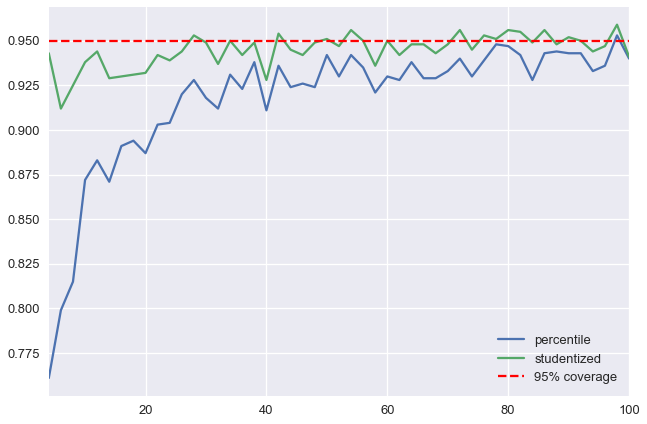

In [41]:
trials.plot()
plt.axhline(0.95, c='red', linestyle='--', label='95% coverage')
plt.legend();

<font color='red'>

- The studentized bootstrap has much better coverage at small sample sizes

As we can see, the studentized bootstrap has a much better coverage at smaller sample sizes.

## Summary
<font color='red'>
- Studentized bootstrap has better coverage than percentile bootstrap, especially at small samples sizes
- We use this method when sample size is small or when original data is skewed
- However, it requires more computation, especially when SE of statistic is not easy to compute.

The studentized bootstrap for the most part is better than the percentile bootstrap, especially if we only have a small sample to start with. We generally want to use this method when the sample size is small or when the original data is skewed. The main drawback is its computation time, which is further magnified if $SE(\tilde\theta)$ is not easy to compute.